In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Session 3 – Transformers and Model Architectures

> The emergence of Transformers dramatically changed the NLP landscape. While RNNs and LSTMs are still valuable for certain scenarios, Transformers excel in most tasks due to their powerful self-attention mechanism and ability to scale to massive datasets. Mastering both architectures gives you a well-rounded understanding of modern NLP.

In the previous sessions, we explored **RNNs and LSTMs**, which have been foundational for sequential tasks. Now, we transition to **Transformers**—the architecture that has revolutionized NLP in recent years. 

**Session Description**:  
This session covers the **fundamental concepts** behind Transformer architectures, including **self-attention**, **encoders/decoders**, and **their advantages over RNNs**. We’ll also look at **positional encodings**, and differences among **encoder-based (BERT)**, **decoder-based (GPT)**, and **sequence-to-sequence models (T5)**.


## Table of Contents

1. [Introduction: Why Move Beyond RNNs?](#introduction)
1. [Transformer Basics](#transformer-basics)
   - [Self-Attention](#self-attention)
   - [Multi-Head Attention](#multi-head-attention)
   - [Positional Encoding](#positional-encoding)
1. [High-Level Transformer Architecture](#transformer-architecture)
   - [Encoder, Decoder, & Seq2Seq](#encoder-decoder-seq2seq)
   - [Example: BERT vs. GPT vs. T5](#bert-gpt-t5)
1. [Minimal Transformer Implementation in PyTorch](#minimal-transformer)
   - [Positional Encoding from Scratch](#pos-enc-scratch)
   - [Building a Simple Transformer Block](#simple-transformer-block)
   - [Visualizing Attention Weights](#visualizing-attention)
1. [(Optional) Brief Notes on Data Preprocessing](#brief-preprocessing)
1. [(Optional) Training a Transformer](#training-transformer)
1. [Conclusion](#conclusion)

Each major concept includes an **Exercise** to help reinforce your understanding. Let’s dive in!


## <a id="introduction"></a>1. Introduction: Why Move Beyond RNNs?

**RNNs** (and their variants, LSTMs, GRUs) were once the state-of-the-art for many NLP tasks. However, they come with **limitations**:

1. **Sequential Computation**: RNNs process tokens one by one, which can be slow for long sequences.  
2. **Long-Term Dependencies**: Even with gating (LSTMs, GRUs), very long sequences can still cause issues (vanishing gradients).  
3. **Parallelization Difficulty**: Because each step depends on the previous hidden state, parallelizing training or inference is more challenging.

**Transformers** address these issues by using **attention mechanisms**—particularly **self-attention**—to process tokens in **parallel** and model long-range dependencies more effectively.

### Exercise 1: Recap RNN Limitations
**Goal**:  
Write a short paragraph summarizing the main challenges you faced (or foresee) when using RNNs for large, complex sequences. How might a parallelizable architecture help?
*(No code needed—just a conceptual reflection.)*


## <a id="transformer-basics"></a>2. Transformer Basics

The **Transformer** architecture, introduced in the paper “Attention Is All You Need” (Vaswani et al., 2017), replaces recurrence with **self-attention** as its core building block. 

### <a id="self-attention"></a>Self-Attention

**Key Idea**: Each token in the input attends to every other token, learning contextual relationships without sequential operations.

1. **Queries (Q)**, **Keys (K)**, and **Values (V)** are computed from each input token.  
2. The **attention score** for a given token is the similarity (e.g., dot product) between its **query** and other tokens’ **keys**.  
3. Weighted sums of **values** produce the self-attended representation.

Formally, one head of attention is:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

### <a id="multi-head-attention"></a>Multi-Head Attention

Instead of using a single attention function, **multi-head attention** runs several in parallel:
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O
$$
Each head captures different aspects of pairwise relationships (e.g., syntactic vs. semantic dependencies).


### <a id="positional-encoding"></a>Positional Encoding

Because self-attention does **not** inherently encode sequence order (unlike RNNs), Transformers use **positional encodings** to inject sequence position information. A common approach is **sinusoidal encoding**:
$$
PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right), \quad
PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$
This allows the model to learn both relative and absolute positions in the sequence.


### Exercise 2: Calculate Self-Attention by Hand
**Goal**:  
1. Take a small sequence of 3 tokens with embedding size 2. Create random Q, K, V (e.g., by hand or with small random numbers).  
2. Manually compute the attention scores and output.  
3. Compare with a PyTorch snippet that does the same operation.  

*(Focus on the concept—this is to solidify how queries, keys, and values interact.)*

## <a id="transformer-architecture"></a>3. High-Level Transformer Architecture

A typical **Transformer** stack includes:
1. **Embedding** + **Positional Encoding** (for each token in the input).
2. **Encoder**: multiple layers of multi-head self-attention + feedforward sub-layers.
3. **Decoder**: similarly stacked, but it attends to the encoder’s outputs in addition to self-attending to its own inputs.


### <a id="encoder-decoder-seq2seq"></a>Encoder, Decoder, & Seq2Seq

- **Encoder-only** (like **BERT**): Great for classification, sentence embedding, etc.  
- **Decoder-only** (like **GPT**): Autoregressive generation, next-token prediction.  
- **Encoder-Decoder** (like **T5**, **BART**): Sequence-to-sequence tasks (translation, summarization).

**Why is this powerful?**  
- The entire sequence can be processed in **parallel** within each attention block.  
- Long-distance dependencies can be learned more easily via attention.


### <a id="bert-gpt-t5"></a>Example: BERT vs. GPT vs. T5

1. **BERT (Encoder-based)**:
   - Uses **masked language modeling** and **next-sentence prediction** pretraining tasks.
   - Great for classification or token-level tasks (NER, QA).
2. **GPT (Decoder-based)**:
   - Uses **causal (autoregressive) attention** to predict next token.
   - Great for text generation.
3. **T5 (Encoder-Decoder)**:
   - “Text-to-text” framework: everything is cast as a text input → text output problem (translation, summarization, etc.).
   - The encoder reads the input, the decoder generates the output.


### Exercise 3: Compare Model Families
**Goal**:  
- Write 1–2 paragraphs explaining a real-world use case for each model class (encoder-only, decoder-only, seq2seq).  
- Which tasks do you think an encoder-decoder would excel at, and why?

## <a id="minimal-transformer"></a>4. Minimal Transformer Implementation in PyTorch

Let’s build **from scratch** a simple Transformer block. We won’t train a full large model here, but we’ll cover essential code for:

1. **Positional Encoding**  
2. **Multi-Head Self-Attention**  
3. **Feed-Forward Network (FFN)**  
4. **Putting it together**  

*(Note: PyTorch also provides `nn.Transformer` and related layers, but it’s instructive to implement a simplified version for clarity.)*


### <a id="pos-enc-scratch"></a>Positional Encoding from Scratch

**Explanation**: 
- We generate a big matrix for positions up to `max_len`. 
- We use `sin` and `cos` on even/odd indices to encode position.


In [1]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # shape => (1, max_len, d_model) so we can broadcast
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        x shape: (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        # add in positional encoding
        x = x + self.pe[:, :seq_len, :]
        return x

(np.float64(0.0), np.float64(256.0), np.float64(256.0), np.float64(0.0))

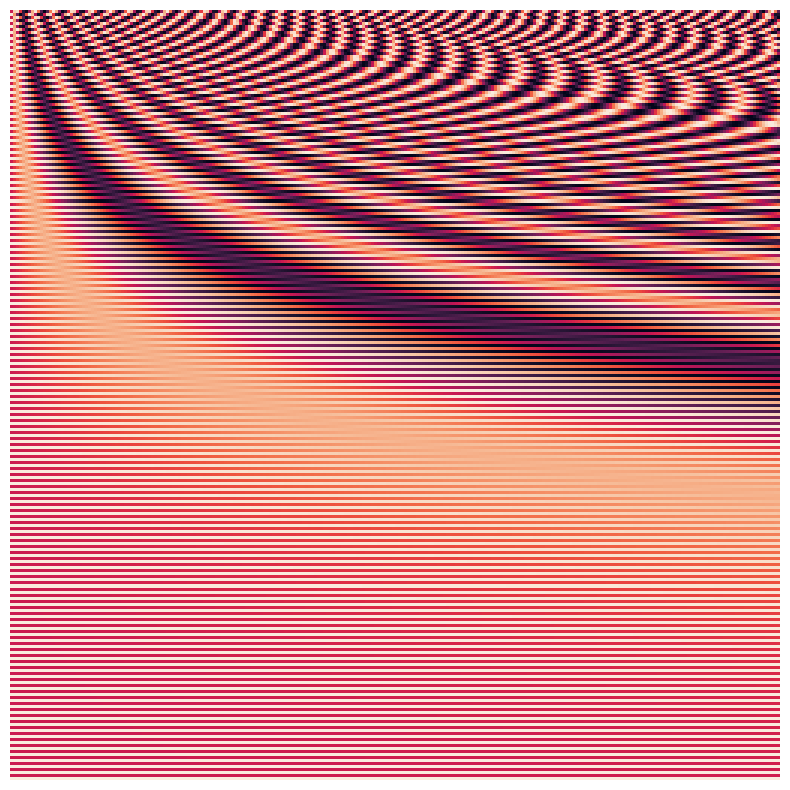

In [65]:
import seaborn as sns

pe = PositionalEncoding(d_model=256, max_len=256)
x = torch.zeros(1, 256, 256)
pos = pe(x)[0].numpy()  # (seq_len, d_model)
plt.figure(figsize=(10, 10))
sns.heatmap(pos, annot=False, cbar=False, square=True)
plt.gca().axis("off")

### <a id="simple-transformer-block"></a>Building a Simple Transformer Block

**Notes**:  
- The `mask` argument can be used for causal masking in a decoder or padding masking in an encoder.  
- We apply **residual connections** and **layer normalization** after each sublayer, as in the original Transformer.


In [3]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, d_model)
        B, T, _ = x.size()
        
        Q = self.linear_q(x).view(B, T, self.num_heads, self.d_k)
        K = self.linear_k(x).view(B, T, self.num_heads, self.d_k)
        V = self.linear_v(x).view(B, T, self.num_heads, self.d_k)
        
        # permute => (batch_size, num_heads, seq_len, d_k)
        Q = Q.permute(0, 2, 1, 3)
        K = K.permute(0, 2, 1, 3)
        V = V.permute(0, 2, 1, 3)
        
        # scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)  # shape => (batch_size, num_heads, seq_len, d_k)
        
        # reshape back
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(B, T, self.d_model)
        out = self.linear_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # 1) Self-attention + residual
        attn_out = self.attn(x, mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # 2) Feed-forward + residual
        ff_out = self.ff(x)
        x = x + self.dropout(ff_out)
        x = self.norm2(x)
        
        return x

### Putting It All Together in a Minimal Encoder

This is a *very* simplified version of an **encoder**. A **decoder** would also incorporate a second attention block that attends to the encoder output.


In [4]:
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2, max_len=5000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads) for _ in range(num_layers)
        ])
    
    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)   # => (batch_size, seq_len, d_model)
        embedded = self.pos_encoding(embedded)
        
        out = embedded
        for layer in self.layers:
            out = layer(out, mask)
        return out


### <a id="visualizing-attention"></a>Visualizing Attention Weights

To visualize attention:
1. Modify `MultiHeadSelfAttention` to **return** the `attn` (attention weights).  
2. Plot them using a heatmap (e.g., `matplotlib.seaborn.heatmap`).

In [6]:
# Quick demonstration of capturing attention
class MultiHeadSelfAttentionReturnWeights(MultiHeadSelfAttention):
    def forward(self, x, mask=None):
        B, T, _ = x.size()
        
        Q = self.linear_q(x).view(B, T, self.num_heads, self.d_k).permute(0, 2, 1, 3)
        K = self.linear_k(x).view(B, T, self.num_heads, self.d_k).permute(0, 2, 1, 3)
        V = self.linear_v(x).view(B, T, self.num_heads, self.d_k).permute(0, 2, 1, 3)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)
        
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, self.d_model)
        out = self.linear_out(out)
        return out, attn

# Then, in your code, replace the old attention with "ReturnWeights" variant and visualize.


### Exercise 4: Simple Transformer Tests
1. **Implement** the attention-weight-return version above.  
2. Pass a small batch (like random token IDs) through the encoder.  
3. Plot the attention heatmap for each head.  
4. Observe how each head “pays attention” to different positions in the sequence.

## <a id="brief-preprocessing"></a>5. (Optional) Brief Notes on Data Preprocessing

While the **focus** of this session is modeling, recall from previous sessions that **preprocessing** for Transformers typically involves **subword tokenization** (e.g., BPE or WordPiece), special tokens (like `[CLS]`, `[SEP]`), and attention masks for padding. Tools like **Hugging Face**’s `transformers` and `tokenizers` libraries handle these details seamlessly.


## <a id="training-transformer"/>6. (Optional) Training a Simple Transformer Decoder for Causal Language Modeling

In this optional section, we’ll demonstrate how to train a **Transformer Decoder** in a **causal language modeling** setup (like GPT). We’ll use a **tiny Shakespeare** dataset to keep things manageable. The key ideas are:

1. **Decoder-Only Architecture**: We only stack self-attention blocks, no separate encoder.  
2. **Causal Mask (Triangular Mask)**: Ensures each token only attends to itself and previous tokens, not future ones.  
3. **Next-Token Prediction**: At each time step, predict the *next* character (or token).

Below is a step-by-step guide and a minimal code outline.


### A. Preparing a Tiny Shakespeare Dataset

For demonstration, assume you have a file named `tiny_shakespeare.txt` (you can get a version from [Andrej Karpathy’s repo](https://github.com/karpathy/char-rnn) or anywhere else). Let’s read it in and do a simple **character-level** approach:


**Note**: For a more advanced approach, you could use subword tokenization. But character-level is straightforward for a small dataset.


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math

# 1) Load a small Shakespeare corpus
with open("tiny_shakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Corpus length:", len(text))

# 2) Build a character-level vocab
chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

print(f"Vocabulary size: {vocab_size}")

# Convert text to indices
data = [char2idx[ch] for ch in text]
data_tensor = torch.tensor(data, dtype=torch.long)

# Let's define some hyperparameters
seq_length = 64  # chunk size
batch_size = 32

Corpus length: 1115394
Vocabulary size: 65



### B. Creating a Causal LM Dataset

We want each sequence to predict the *next* character for each position. So if our sequence is \([x_0, x_1, ..., x_{t}]\), we want to predict \([x_1, x_2, ..., x_{t+1}]\). We can store them as `(input_seq, target_seq)` pairs.

Here, `x_seq[i]` should predict `y_seq[i]`, shifting by one character.


In [9]:
class ShakespeareCharDataset(Dataset):
    def __init__(self, data_tensor, seq_length=64):
        self.data = data_tensor
        self.seq_length = seq_length
        # We'll create as many full chunks as possible
        self.num_samples = len(self.data) // seq_length - 1
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = idx * self.seq_length
        x_seq = self.data[start : start + self.seq_length]
        y_seq = self.data[start + 1 : start + self.seq_length + 1]
        return x_seq, y_seq

dataset = ShakespeareCharDataset(data_tensor, seq_length=seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print("Num batches:", len(dataloader))

Num batches: 544



### C. Building a Causal Decoder Model

We’ll adapt our **TransformerBlock** for a **decoder-only** scenario. The main difference is applying a **causal mask** so tokens cannot attend to future positions.

#### 1. Causal Mask Function

A common technique is to create a **triangular** attention mask of shape `(seq_length, seq_length)` where positions `j > i` are masked out.

In [10]:
def generate_causal_mask(seq_length):
    """
    Returns a (seq_length, seq_length) mask,
    where positions j>i are set to False (meaning "do not attend").
    """
    # shape (seq_length, seq_length)
    mask = torch.tril(torch.ones(seq_length, seq_length)).bool()
    return mask  # True means "allowed to attend"



#### 2. Simple DecoderBlock

We can reuse a similar block to our earlier `TransformerBlock`, but we’ll clarify the self-attention is **causal**.

*(We’re assuming the `MultiHeadSelfAttention` class from the prior session or snippet, which can apply `mask` to the `scores`.)*


In [12]:

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # 1) Causal self-attention + residual
        attn_out = self.attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # 2) Feed-forward + residual
        ff_out = self.ff(x)
        x = x + self.dropout(ff_out)
        x = self.norm2(x)
        
        return x


#### 3. Decoder Model

We can define a small model that:
1. Embeds characters,
2. Adds positional encoding,
3. Stacks `DecoderBlock` layers,
4. Outputs logits over the vocabulary at each time step.

Note how we generate the `causal_mask(T,T)` and pass it along so each token can’t attend to future positions.


In [14]:

class CausalTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2, max_len=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        """
        x: (batch_size, seq_length) of token indices
        returns: (batch_size, seq_length, vocab_size)
        """
        B, T = x.size()
        # Embeddings + positions
        embed = self.embedding(x)  # (B, T, d_model)
        embed = self.pos_encoding(embed)  # add positional info
        
        # Generate causal mask (for each batch, we broadcast the same mask)
        mask = generate_causal_mask(T).to(x.device)  # (T, T)
        
        out = embed
        for layer in self.layers:
            out = layer(out, mask=mask)
        
        # Predict next char at each position
        logits = self.fc_out(out)  # (B, T, vocab_size)
        return logits



### D. Training Loop

We’ll do **cross-entropy** on each position’s next-char prediction.

For a small dataset (like `tiny_shakespeare.txt`), you might want more epochs or a smaller `d_model`. The final model can then do **character-level generation** using a standard autoregressive approach:


In [17]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = CausalTransformerDecoder(vocab_size, d_model=512, num_heads=4, num_layers=3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for x_seq, y_seq in dataloader:
        x_seq, y_seq = x_seq.to(device), y_seq.to(device)
        
        optimizer.zero_grad()
        # logits: (batch_size, seq_length, vocab_size)
        logits = model(x_seq)
        
        # reshape for cross-entropy
        # we want (batch_size*seq_length, vocab_size) vs. (batch_size*seq_length)
        logits_reshaped = logits.view(-1, vocab_size)
        targets_reshaped = y_seq.view(-1)
        
        loss = criterion(logits_reshaped, targets_reshaped)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Using device: cuda
Epoch 1/10, Loss: 2.0594
Epoch 2/10, Loss: 1.6656
Epoch 3/10, Loss: 1.5849
Epoch 4/10, Loss: 1.5376
Epoch 5/10, Loss: 1.5037
Epoch 6/10, Loss: 1.4699
Epoch 7/10, Loss: 1.4487
Epoch 8/10, Loss: 1.4221
Epoch 9/10, Loss: 1.4065
Epoch 10/10, Loss: 1.4026



### E. Generating Shakespeare-Like Text

After training, you can generate text:

**Notes**:
- Adjust `temperature` for more or less randomness.
- If the dataset is tiny, results may still be partially gibberish. You can experiment with more epochs or a bigger model dimension.


In [18]:

def generate_text(model, start_str="ROMEO:", max_new_tokens=200, temperature=1.0):
    model.eval()
    # Convert start_str to indices
    input_ids = torch.tensor([char2idx[ch] for ch in start_str], dtype=torch.long).unsqueeze(0).to(device)
    
    # We'll generate token by token
    for _ in range(max_new_tokens):
        # Get logits for the last token
        logits = model(input_ids)  # shape: (1, seq_len, vocab_size)
        logits = logits[:, -1, :]  # only the last time step
        logits = logits / temperature
        
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, 1).item()
        
        # Append to sequence
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)
    
    # Convert back to characters
    generated_seq = [idx2char[t.item()] for t in input_ids[0]]
    return "".join(generated_seq)

sample_output = generate_text(model, start_str="ROMEO:", max_new_tokens=300, temperature=0.8)
print("Generated:\n", sample_output)



Generated:
 ROMEO:
Sir, which, they know you have, and my weep to sit
Thy maide ke turridstistove orrrrrke pe skinsty stharche prrrke,l'torige h stile in ch agesos we de ly mblablosty y fty ble,ntharkinge f morkes tarrch forkingrty t, s tinge parkes h ie tinge R s s fourch orkin infounges we y forrkimanghaly forkiche



### Summary of This Optional Section

- We showed a **decoder-only Transformer** for **causal language modeling**.
- We used a **triangular mask** to prevent each token from attending to future positions.
- We trained it on a **tiny Shakespeare** dataset with a **character-level** approach.

**Advantages**:
- This approach is the conceptual basis for **GPT-like** models (decoder-based Transformers).
- You can scale up the same logic for bigger datasets and more layers.

Feel free to explore:
- **Subword tokenization** for improved text quality.  
- **More layers** or bigger hidden dimensions.  
- **Longer training** if you have the resources.

## <a id="conclusion"></a>7. Conclusion

**Key Takeaways**:
1. **Self-Attention** provides a parallelizable mechanism that can handle **long-distance dependencies** better than RNNs.  
2. **Multi-Head** setups capture different relational aspects simultaneously.  
3. **Positional Encodings** introduce sequence order into an otherwise order-agnostic attention mechanism.  
4. Transformers come in **encoder-only** (BERT), **decoder-only** (GPT), and **encoder-decoder** (T5) variants, each suited for different tasks.

With the knowledge from **Session 2 (RNNs)** and **Session 3 (Transformers)**, you’re now well-equipped to:
- **Implement** or **fine-tune** these models.
- **Explore** how attention reveals interpretability.
- **Optimize** training for large-scale tasks (though we didn’t dive deeply into that here).


---

# Fun: Train a Shakespearean Transformer Model